# Illustrating all methods and procedures from article:

Illustrating conformal prediction, LOCART, LOFOREST and A-LOFOREST in simulated examples:

In [134]:
import pandas as pd
import numpy as np

from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# packages to create nnet
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import os

original_path = os.getcwd()

# figure path
images_dir = "figures"

from clover.locart import RegressionSplit
from clover.locart import LocartSplit, RegressionScore
from clover.utils import split


import seaborn as sns
import matplotlib.pyplot as plt

def make_data(n, std_dev=1/5, seed = 1250):
    np.random.seed(seed)
    
    if isinstance(n, int):
        x = np.random.uniform(-1, 1, n)
        y = (x**3) + 2 * np.exp(-6 * (x - 0.3)**2)
        y = y + np.random.normal(0, std_dev, n)
        return pd.DataFrame({'x': x, 'y': y})
    else:
        data_list = []
        for n_fixed in n:
            x = np.random.uniform(-1, 1, n_fixed)
            y = (x**3) + 2 * np.exp(-6 * (x - 0.3)**2)
            y = y + np.random.normal(0, std_dev, n_fixed)
            data_list.append(pd.DataFrame({'x': x, 'y': y}))
        return(data_list)

def make_variable_data(n, std_dev=1/5, hetero_value = 0.05, seed = 1250):
    np.random.seed(seed)

    if isinstance(n, int):
        x = np.random.uniform(-1, 1, n)
        y = (x**3) + 2 * np.exp(-6 * (x - 0.3)**2)
        y = y + np.random.normal(0, hetero_value + (std_dev * np.abs(x)), n)
        return pd.DataFrame({'x': x, 'y': y})
    else:
        data_list = []
        for n_fixed in n:
            x = np.random.uniform(-1, 1, n_fixed)
            y = (x**3) + 2 * np.exp(-6 * (x - 0.3)**2)
            y = y + np.random.normal(0, hetero_value + (std_dev * np.abs(x)), n_fixed)
            data_list.append(pd.DataFrame({'x': x, 'y': y}))
        return(data_list)

We will use a one hidden layer feed forward neural network as our base model for the toy examples:

In [135]:
class Net(nn.Module):
    def __init__(self, input_dim, first_l = 4, random_state = 650):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, first_l)  # input layer to first hidden layer
        self.fc2 = nn.Linear(first_l, 1)
        self.random_numpy = random_state

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                gain = nn.init.calculate_gain("relu")
                nn.init.xavier_normal_(m.weight, gain=gain)

    def plot_history(self):
        plt.plot(self.epoch_list, self.loss_history_train, color="tab:red", label = "training loss")
        plt.plot(self.epoch_list, self.loss_history_validation, color="tab:blue", label = "validation loss")
        plt.legend()
        plt.xlabel("Epoch")
        plt.ylabel("Loss")

    def forward(self, x):
        x = F.tanh(self.fc1(x))  # activation function for hidden layer
        x = self.fc2(x)
        return x

    def predict(self, x):
        # first scaling
        x = self.scaler.transform(x)
        x = torch.tensor(x, dtype = torch.float32)
        with torch.no_grad():
            return self.forward(x).numpy().reshape(-1)

    def fit(self, x_train, y_train, val_size = 0.3, epochs = 1000, batch_size = 150, lr = 0.005, patience = 30):
        # scaling data
        self.scaler = StandardScaler()
        x_train = self.scaler.fit_transform(x_train)

        # splitting into training and validation sets
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = val_size, 
                                                          random_state = self.random_numpy)
        
        # encoding data into torch tensor
        x_train, x_val = torch.tensor(x_train, dtype = torch.float32), torch.tensor(x_val, dtype = torch.float32)
        y_train, y_val = torch.tensor(y_train, dtype = torch.float32).view(-1, 1), torch.tensor(y_val, dtype = torch.float32).view(-1, 1)

        # Create Tensor datasets
        train_data = TensorDataset(x_train, y_train)
        val_data = TensorDataset(x_val, y_val)
        
        criterion = nn.MSELoss()
        optimizer = optim.Adamax(self.parameters(), lr=lr)

        # Early stopping initialization
        best_loss = np.inf
        counter = 0

        # tracking loss and epochs
        self.loss_history_validation = []
        self.loss_history_train = []
        self.epoch_list = []
        self.best_loss_history_val = []

        # Create DataLoaders
        train_loader = DataLoader(train_data, shuffle=True, batch_size = batch_size)
        val_loader = DataLoader(val_data, shuffle=True, batch_size = batch_size)

        for epoch in range(epochs):  # number of epochs
            with torch.set_grad_enabled(True):
                loss_vals_train = []
                for inputs, labels in train_loader:
                    inputs.requires_grad_(True)

                    optimizer.zero_grad()
                    outputs = self(inputs)

                    loss = criterion(outputs, labels)
                    loss_vals_train.append(loss.data.item())

                    loss.backward()
                    optimizer.step()

                avgloss_train = np.average(loss_vals_train)
                self.loss_history_train.append(avgloss_train)

            # Validation step
            loss_vals = []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    val_outputs = self(inputs)
                    val_loss = criterion(val_outputs, labels)
                    loss_vals.append(val_loss.data.item())

            avgloss_valid = np.average(loss_vals)
            self.loss_history_validation.append(avgloss_valid)

            self.epoch_list.append(epoch)
            # Early stopping
            if avgloss_valid < best_loss:
                best_loss = avgloss_valid
                self.best_loss_history_val.append(best_loss)
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

        print(f'Final loss: {avgloss_valid}')
        return self

In [136]:
torch.manual_seed(45)
# set sizes
n_train, n_cal, n_test = 1000, 1000, 1000
alpha = 0.1

# homoscedastic data
train_data = make_data(n_train, seed = 1250)
model_1 = Net(input_dim = 1, first_l = 4)
model_1.fit(train_data[['x']].values, train_data['y'].values)

# Generate a calibration dataset
calibration_data = make_data(n_cal, seed = 1000)

# fit regression split to the model
reg_split_1 = RegressionSplit(model_1, alpha = alpha, is_fitted = True)
reg_split_1.fit(train_data[['x']].values, train_data['y'].values)
reg_split_1.calibrate(calibration_data[['x']].values, calibration_data['y'].values)

# heteroscedastic data
train_data = make_variable_data(n_train, seed = 1250)
model_2 = Net(input_dim = 1, first_l = 4)
model_2.fit(train_data[['x']].values, train_data['y'].values)

# Generate a calibration dataset
calibration_data = make_variable_data(n_cal, seed = 1000)

# fit regression split to the model
reg_split_2 = RegressionSplit(model_2, alpha = alpha, is_fitted = True)
reg_split_2.fit(train_data[['x']].values, train_data['y'].values)
reg_split_2.calibrate(calibration_data[['x']].values, calibration_data['y'].values)

Early stopping at epoch 806
Final loss: 0.04510618932545185
Final loss: 0.03004529792815447


Plotting both regression split prediction intervals in the same figure:

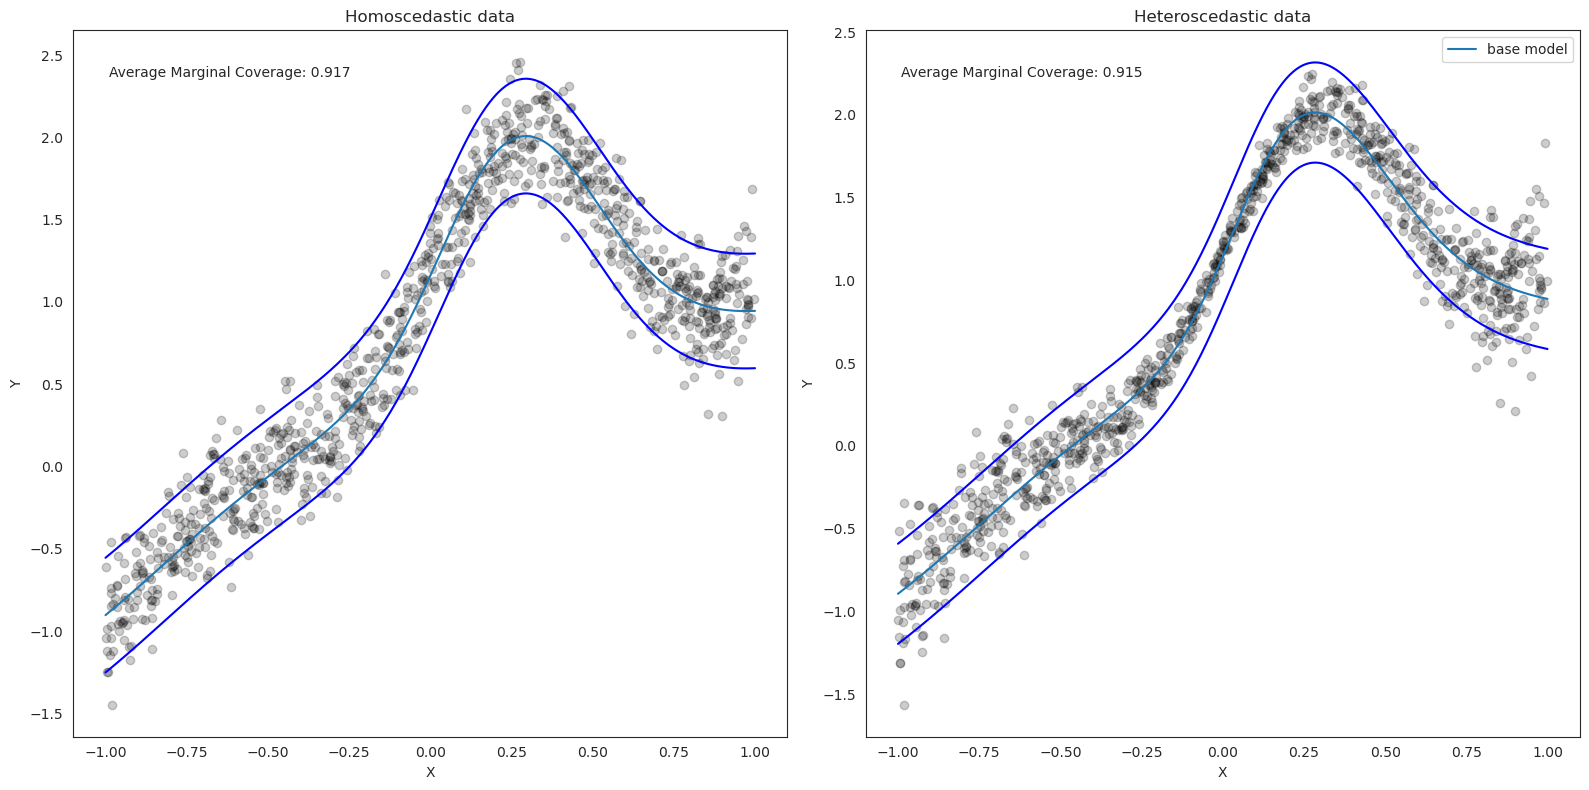

In [137]:
# Set the style to 'seaborn-white'
sns.set_style('white')

# Create a test set
test_data_1 = make_data(n_test, seed = 750)
test_data_2 = make_variable_data(n_test, seed = 750) 

# Prepare the test data
x_test_1 = test_data_1[['x']].values
y_test_1 = test_data_1['y'].values

x_test_2 = test_data_2[['x']].values
y_test_2 = test_data_2['y'].values

# Create a grid of x values
x_grid = np.linspace(-1, 1, 500).reshape(-1, 1)

# Use the trained model to make predictions on the x grid
y_grid_1 = model_1.predict(x_grid)

reg_split_values_1 = reg_split_1.predict(x_grid)
reg_split_values_2 = reg_split_2.predict(x_grid)


# computing marginal coverage
pred_1 = reg_split_1.predict(x_test_1)
pred_2 = reg_split_2.predict(x_test_2)

marg_coverage_1 = np.logical_and(y_test_1 >= pred_1[:, 0], 
        y_test_1 <= pred_1[:, 1]) + 0
marg_coverage_2 = np.logical_and(y_test_2 >= pred_2[:, 0], 
        y_test_2 <= pred_2[:, 1]) + 0

fig, axs = plt.subplots(1, 2, figsize = (16, 8))

# Plot for reg_split_values_1
axs[0].scatter(test_data_1['x'], test_data_1['y'], alpha=1/5, color = 'black')
axs[0].plot(x_grid, y_grid_1, color = 'tab:blue', label = "base model")
axs[0].plot(x_grid, reg_split_values_1[:,0], color = "blue")
axs[0].plot(x_grid, reg_split_values_1[:,1], color = "blue")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title('Homoscedastic data')

# Annotate marg_coverage_1
axs[0].text(0.05, 0.95, f'Average Marginal Coverage: {marg_coverage_1.mean():.3f}', 
            transform=axs[0].transAxes,
              verticalalignment='top')

# Use the trained model to make predictions on the x grid for second model
y_grid_2 = model_2.predict(x_grid)

# Plot for reg_split_values_2
axs[1].scatter(test_data_2['x'], test_data_2['y'], alpha=1/5, color = 'black')
axs[1].plot(x_grid, y_grid_2, color = 'tab:blue', label = "base model")
axs[1].plot(x_grid, reg_split_values_2[:,0], color = "blue")
axs[1].plot(x_grid, reg_split_values_2[:,1], color = "blue")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_title('Heteroscedastic data')

# Annotate marg_coverage_2
axs[1].text(0.05, 0.95, f'Average Marginal Coverage: {marg_coverage_2.mean():.3f}', 
            transform=axs[1].transAxes, 
            verticalalignment='top')

plt.tight_layout()
plt.legend()
plt.savefig('figures/reg_split_example.pdf')

To obtain the local regression split, let $\mathcal{A} = \{A_1, A_2, \dots, A_K\}$ be a partition of the heteroscedastic data. We consider in this case the following partition:
- $A_1 = (-1, -0.5)$
- $A_2 = [-0.5, -0.25)$
- $A_3 = [-0.25, 0.25)$
- $A_4 = [0.25, 0.5)$
- $A_5 = [0.5, 1)$

In [138]:
def apply_local(x_data):
    limits = np.array([-0.5, -0.25, 0.25, 0.5, 1])
    int_idx = np.zeros(x_data.shape[0])
    i = 0
    for x in x_data:
        index = np.where(x <= limits)[0]
        int_idx[i] = index[0]
        i += 1
    return int_idx.astype(int)

def obtain_local_cutoffs(x_data, y_data, preds, alpha = 0.1):
    int_idx = apply_local(x_data)
    res = np.abs(y_data - preds)
    cutoffs = np.zeros(5)
    for i in range(0, 5):
        current_res = res[np.where(int_idx == i)]
        n = current_res.shape[0]
        cutoffs[i] = np.quantile(
                current_res, q=np.ceil((n + 1) * (1 - alpha)) / n
            )
    return cutoffs

def predict_local(x_data, cutoffs, pred):
    idxs = apply_local(x_data)
    cutoffs_local = cutoffs[idxs]
    pred_int = np.vstack((pred - cutoffs_local, pred + cutoffs_local)).T
    return pred_int

Applying the manually defined local conformal split in the simulated example: 

In [139]:
# deriving cutoffs using the calibration data
calibration_data = make_variable_data(n_cal, seed = 1000)
pred_calib = model_2.predict(calibration_data[['x']].values)
local_cutoffs = obtain_local_cutoffs(calibration_data[['x']].values, calibration_data['y'].values, pred_calib)

# predicting for both x_test and x_grid
pred_model_2 = model_2.predict(x_test_2)
reg_split_local = predict_local(x_data = x_test_2, cutoffs = local_cutoffs, pred = pred_model_2)

marg_coverage_local = (np.logical_and(y_test_2 >= reg_split_local[:, 0], 
        y_test_2 <= reg_split_local[:, 1]) + 0).mean()
marg_coverage_local

0.919

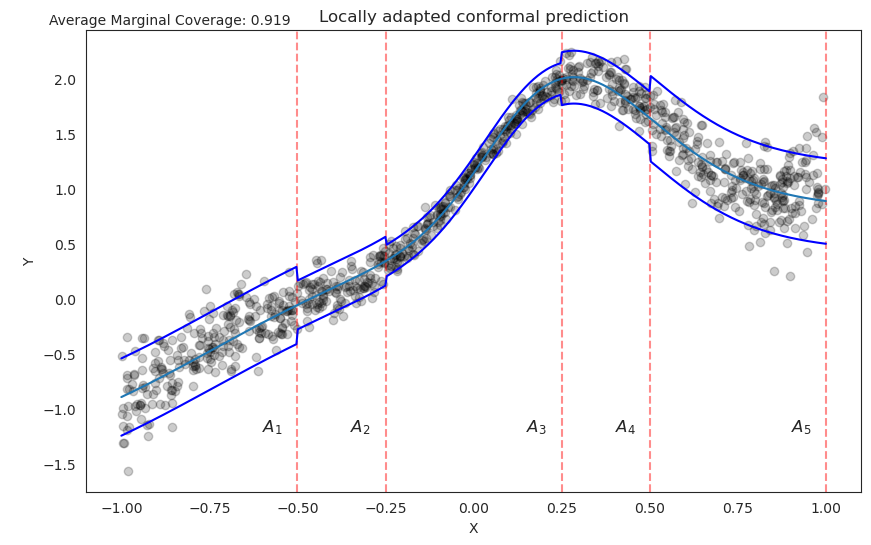

In [140]:
reg_split_local_2 = predict_local(x_data = x_grid, cutoffs = local_cutoffs, pred = model_2.predict(x_grid))

plt.figure(figsize=(10, 6))

partition_limits = [-0.5, -0.25, 0.25, 0.5, 1]
for i, limit in enumerate(partition_limits):
    plt.axvline(x=limit, color='r', linestyle='--', alpha = 0.45)
    plt.text(limit - 0.1, -1.25, r'$A_{}$'.format(i + 1),verticalalignment='bottom', fontsize=12)  # Increase fontsize here


plt.scatter(test_data_2['x'], test_data_2['y'], alpha=1/5, color = 'black')
plt.plot(x_grid, y_grid_2, color = 'tab:blue', label = "base model")
plt.plot(x_grid, reg_split_local_2[:,0], color = "blue")
plt.plot(x_grid, reg_split_local_2[:,1], color = "blue")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Locally adapted conformal prediction")

# Annotate marg_coverage_2
plt.text(-1.15, 0.67, f'Average Marginal Coverage: {marg_coverage_local:.3f}', 
            transform=axs[1].transAxes, 
            verticalalignment='top')
plt.savefig('figures/local_reg_split_example.pdf')

## Illustrating locart using the heteroscedastic example:

Fitting locart to data and computing the test set marginal coverage:

In [141]:
calibration_data = make_variable_data(n_cal, seed = 1000)
# fit locart to the data
locart_split = LocartSplit(nc_score = RegressionScore, base_model = model_2, alpha = alpha, is_fitted = True,
                          split_calib = False)

locart_split.fit(train_data[['x']].values, train_data['y'].values)
locart_split.calib(calibration_data[['x']].values, calibration_data['y'].values, min_samples_split = 100)

pred_locart = locart_split.predict(x_test_2)

marg_coverage_local = (np.logical_and(y_test_2 >= pred_locart[:, 0], 
        y_test_2 <= pred_locart[:, 1]) + 0).mean()
marg_coverage_local

0.919

Discovering partition limits:

In [142]:
# Create a grid of x values
idxs = locart_split.cart.apply(x_grid)
partition_limits = []
for idx in np.unique(idxs):
    partition_limits.append(np.max(x_grid[np.where(idxs == idx)[0]]))

Plotting LOCART predictive intervals next to the derived partition:

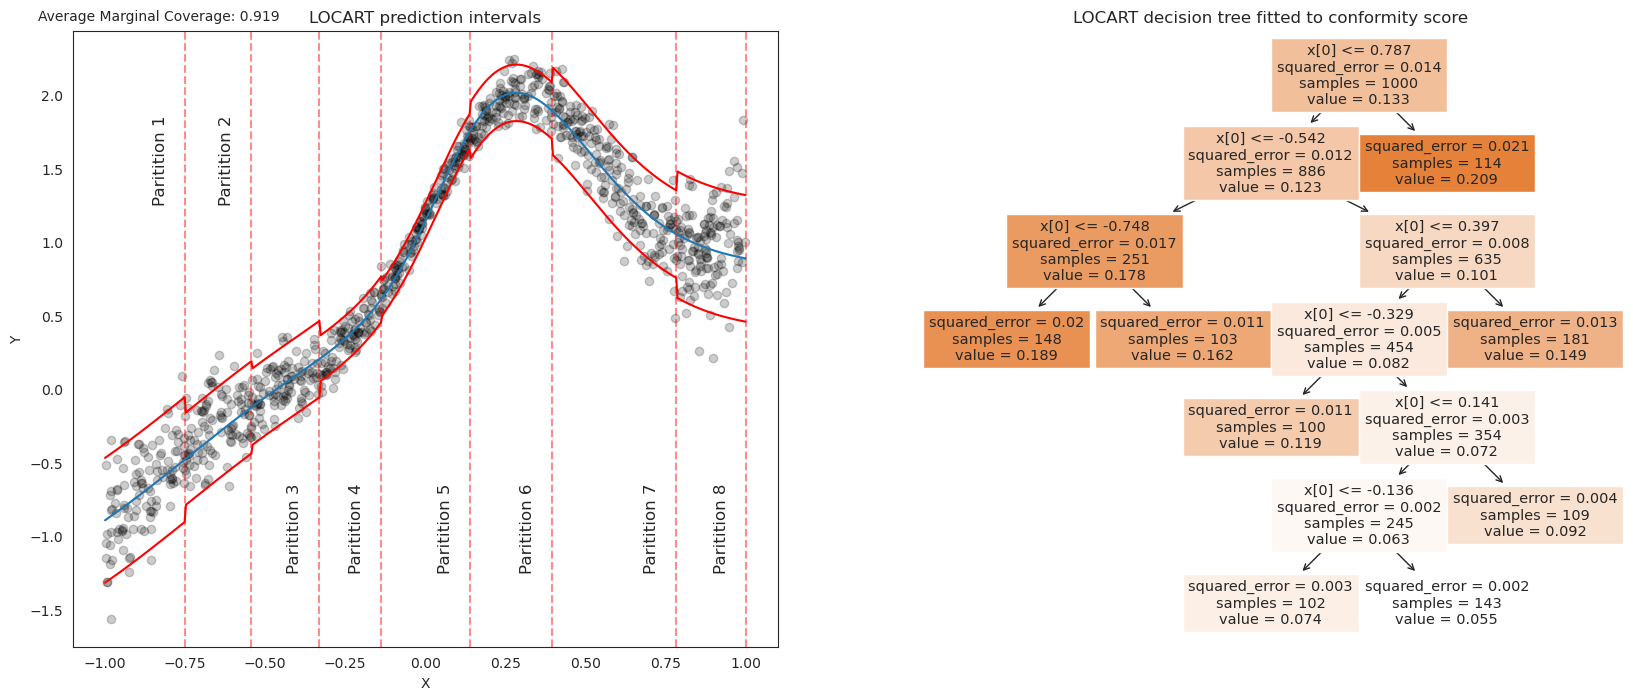

<Figure size 640x480 with 0 Axes>

In [143]:
# Create a grid of x values
locart_pred_grid = locart_split.predict(x_grid)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
for i, limit in enumerate(partition_limits):
    plt.axvline(x=limit, color='r', linestyle='--', alpha = 0.45)
    if i == 0 or i == 1:
        plt.text(limit - 0.1, 1.25, r'Paritition {}'.format(i + 1),rotation = 90, verticalalignment='bottom', fontsize=12)
    else:
        plt.text(limit - 0.1, -1.25, r'Paritition {}'.format(i + 1),rotation = 90, verticalalignment='bottom', fontsize=12)  # Increase fontsize here

plt.savefig('figures/locart_example.pdf')

plt.scatter(test_data_2['x'], test_data_2['y'], alpha=1/5, color = 'black')
plt.plot(x_grid, y_grid_2, color = 'tab:blue', label = "base model")
plt.plot(x_grid, locart_pred_grid[:,0], color = "red")
plt.plot(x_grid, locart_pred_grid[:,1], color = "red")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("LOCART prediction intervals")
plt.text(-0.05, 1.035, f'Average Marginal Coverage: {marg_coverage_local:.3f}', 
            transform=plt.gca().transAxes, 
            verticalalignment='top')

plt.subplot(1, 2, 2)
locart_split.plot_locart(title = "LOCART decision tree fitted to conformity score")
plt.savefig('figures/locart_example.pdf')
plt.show()

## Now, illustrating loforest

In [144]:
calibration_data = make_variable_data(n_cal, seed = 1000)
# fit locart to the data
locart_split = LocartSplit(nc_score = RegressionScore, cart_type = "RF", base_model = model_2, alpha = alpha, is_fitted = True,
                          split_calib = False)
locart_split.fit(train_data[['x']].values, train_data['y'].values)
locart_split.calib(calibration_data[['x']].values, calibration_data['y'].values, min_samples_split = 100, n_estimators = 3, random_state = 45)

pred_locart = locart_split.predict(x_test_2)

marg_coverage_local = (np.logical_and(y_test_2 >= pred_locart[:, 0], 
        y_test_2 <= pred_locart[:, 1]) + 0).mean()
marg_coverage_local

0.922

Discovering partition limits to each tree, and also making predictions for each:

In [145]:
# Create a grid of x values
partition_dict = {}
i = 1
for estimator in locart_split.RF.estimators_:
    partition_limits = []
    idxs = estimator.apply(x_grid)
    for idx in np.unique(idxs):
        partition_limits.append(np.max(x_grid[np.where(idxs == idx)[0]]))
    partition_dict[i] = partition_limits
    i += 1

# creating prediction interval for each
def obtain_cutoffs(estimator, x_calib, y_calib, pred, alpha = 0.1):
    idxs = estimator.apply(x_calib)
    res = np.abs(pred - y_calib)
    cutoffs = {}
    for idx in np.unique(idxs):
        current_res = res[np.where(idxs == idx)]
        n = current_res.shape[0]
        cutoffs[idx] = np.quantile(
                current_res, q=np.ceil((n + 1) * (1 - alpha)) / n
            )
    return cutoffs

def predict_estim(estimator, x_test, cutoff_dict, pred):
    leaves = estimator.apply(x_test)
    cutoffs = np.zeros(x_test.shape[0])
    for i in range(0, x_test.shape[0]):
        cutoffs[i] = cutoff_dict[leaves[i]]
    return np.vstack((pred - cutoffs, pred + cutoffs)).T


Plotting LOFOREST predictive intervals as an agreggation of several local prediction intervals:

In [146]:
partition_dict.keys()

dict_keys([1, 2, 3])

<Figure size 2000x1000 with 0 Axes>

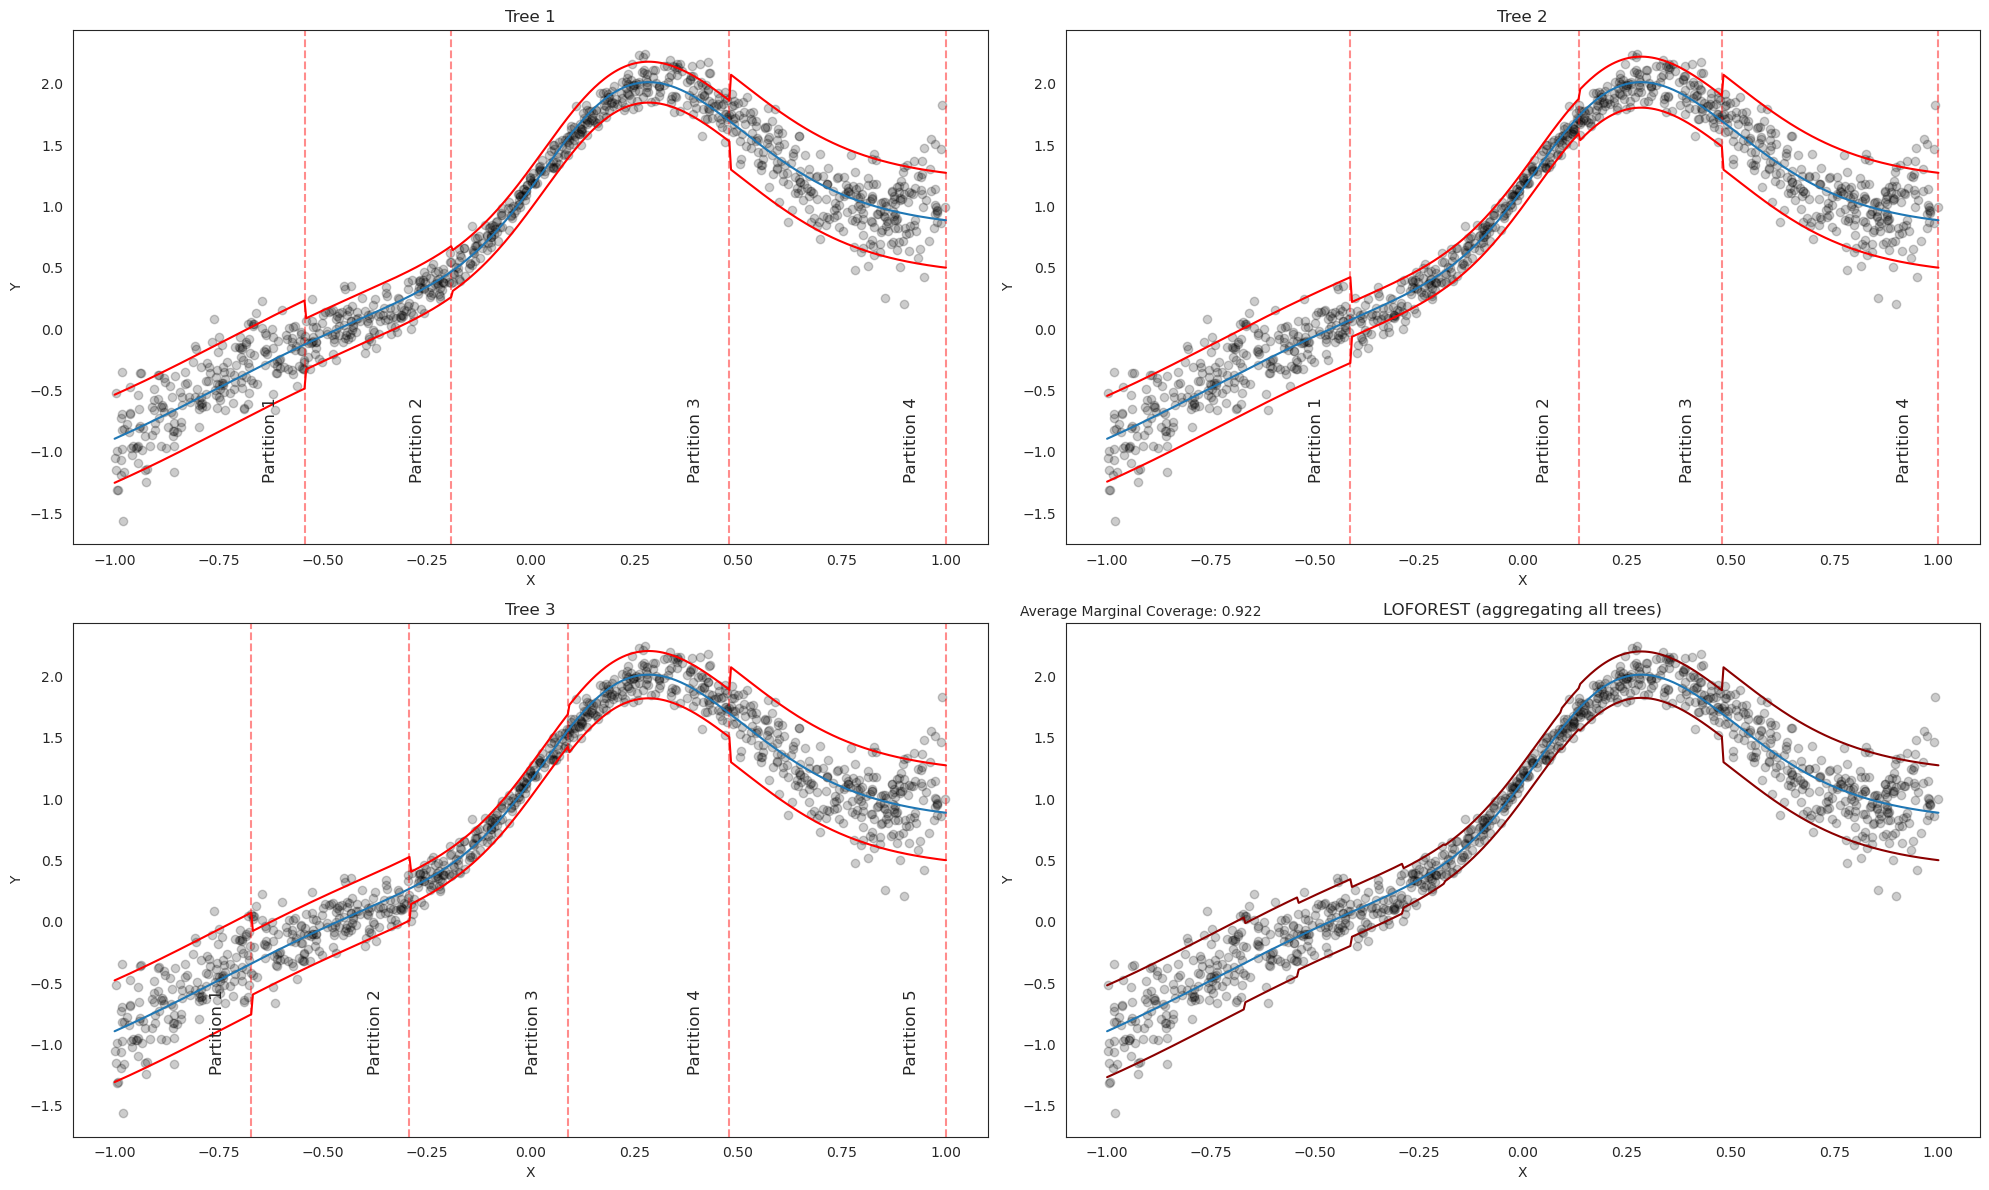

In [147]:
# loforest_predicitons
plt.figure(figsize = (20, 10))
locart_pred_grid = locart_split.predict(x_grid)
estimator_list = locart_split.RF.estimators_
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
ax_list = axes.flatten()

for ax, i in zip(ax_list[:-1], partition_dict.keys()):
    partition_limits = partition_dict[i]
    j = 0
    for value in partition_limits:
        ax.axvline(x=value, color='r', linestyle='--', alpha = 0.45)
        ax.text(value- 0.1, -1.25, r'Partition {}'.format(j + 1),rotation = 90, verticalalignment='bottom', fontsize=12)
        j += 1
    
    tree_cutoff = obtain_cutoffs(estimator_list[i - 1], 
                                 calibration_data[['x']].values, 
                                 calibration_data['y'].values,
                                 pred_calib)
    
    tree_pred = predict_estim(estimator_list[i - 1], x_grid, tree_cutoff, y_grid_2)

    ax.scatter(test_data_2['x'], test_data_2['y'], alpha=1/5, color = 'black')
    ax.plot(x_grid, y_grid_2, color = 'tab:blue', label = "base model")
    ax.plot(x_grid, tree_pred[:,0], color = "red")
    ax.plot(x_grid, tree_pred[:,1], color = "red")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Tree {}".format(i))


ax_list[3].scatter(test_data_2['x'], test_data_2['y'], alpha=1/5, color = 'black')
ax_list[3].plot(x_grid, y_grid_2, color = 'tab:blue', label = "base model")
ax_list[3].plot(x_grid, locart_pred_grid[:,0], color = "darkred")
ax_list[3].plot(x_grid, locart_pred_grid[:,1], color = "darkred")
ax_list[3].set_xlabel("X")
ax_list[3].set_ylabel("Y")
ax_list[3].set_title("LOFOREST (aggregating all trees)")
ax_list[3].text(-0.05, 1.035, f'Average Marginal Coverage: {marg_coverage_local:.3f}', 
            transform=plt.gca().transAxes, 
            verticalalignment='top')

plt.tight_layout()
plt.savefig('figures/loforest_example.pdf')
plt.show()

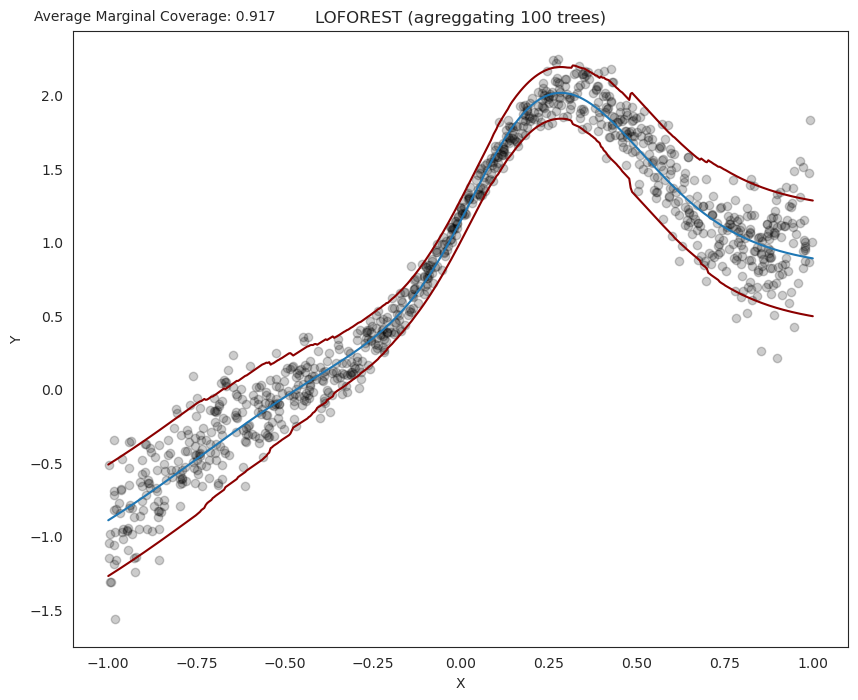

In [148]:
calibration_data = make_variable_data(n_cal, seed = 1000)

# fit locart to the data
locart_split = LocartSplit(nc_score = RegressionScore, cart_type = "RF", base_model = model_2, alpha = alpha, is_fitted = True,
                          split_calib = False)
locart_split.fit(train_data[['x']].values, train_data['y'].values)
locart_split.calib(calibration_data[['x']].values, calibration_data['y'].values, min_samples_split = 100, n_estimators = 100, random_state = 45)

pred_locart = locart_split.predict(x_test_2)

marg_coverage_local = (np.logical_and(y_test_2 >= pred_locart[:, 0], 
        y_test_2 <= pred_locart[:, 1]) + 0).mean()
marg_coverage_local

locart_pred_grid = locart_split.predict(x_grid)

plt.figure(figsize = (10, 8))

plt.scatter(test_data_2['x'], test_data_2['y'], alpha=1/5, color = 'black')
plt.plot(x_grid, y_grid_2, color = 'tab:blue', label = "base model")
plt.plot(x_grid, locart_pred_grid[:,0], color = "darkred")
plt.plot(x_grid, locart_pred_grid[:,1], color = "darkred")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("LOFOREST (agreggating 100 trees)")
plt.text(-0.05, 1.035, f'Average Marginal Coverage: {marg_coverage_local:.3f}', 
            transform=plt.gca().transAxes, 
            verticalalignment='top')

plt.savefig('figures/loforest_smooth_example.pdf')
plt.show()